# Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

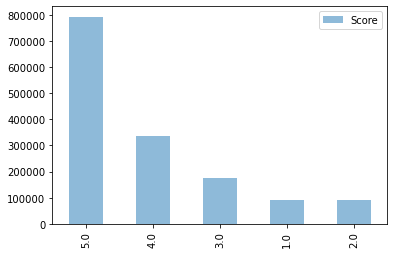


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("datasets/train.csv")
testingSet = pd.read_csv("datasets/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [3]:
sia = SentimentIntensityAnalyzer()

def add_features_to(df):
    print("Initial shape of DataFrame:", df.shape)

    # Calculating Helpfulness
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Calculate UserFrequency and ProductFrequency
    user_frequency = df['UserId'].value_counts()
    product_frequency = df['ProductId'].value_counts()

    df['UserFrequency'] = df['UserId'].map(user_frequency)
    df['ProductFrequency'] = df['ProductId'].map(product_frequency)

    # Calculate SummarySentimentScore
    # Convert the 'Summary' column to string type before applying sia.polarity_scores
    df['Summary'] = df['Summary'].astype(str)
    df['SummarySentimentScore'] = df['Summary'].apply(lambda x: sia.polarity_scores(x)['compound'])
    df['SummarySentiment'] = df['SummarySentimentScore'].apply(lambda score:
        'very negative' if score <= -0.6 else
        'negative' if score <= -0.2 else
        'neutral' if score < 0.2 else
        'positive' if score < 0.6 else
        'very positive'
    )

    # Calculate TextSentimentScore
    # Convert the 'Text' column to string type before applying sia.polarity_scores
    df['Text'] = df['Text'].astype(str)
    df['TextSentimentScore'] = df['Text'].apply(lambda x: sia.polarity_scores(x)['compound'])
    df['TextSentiment'] = df['TextSentimentScore'].apply(lambda score:
        'very negative' if score <= -0.6 else
        'negative' if score <= -0.2 else
        'neutral' if score < 0.2 else
        'positive' if score < 0.6 else
        'very positive'
    )

    return df

In [4]:
# Load the feature extracted files if they've already been generated
if exists('datasets/X_train.csv'):
    X_train = pd.read_csv("datasets/X_train.csv")
if exists('datasets/X_submission.csv'):
    X_submission = pd.read_csv("datasets/X_submission.csv")
else:
    # Process the original training set to extract features
    train = add_features_to(trainingSet)

    # Create the submission set directly from the original training set
    X_submission = pd.merge(train, testingSet, on='Id', how='inner')  # Use 'inner' to ensure matching Ids
    X_submission = X_submission.drop(columns=['Score_x'], errors='ignore')
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is now the processed balanced dataset
    X_train =  train[train['Score'].notnull()]

    # Save the processed DataFrames to CSV
    X_submission.to_csv("datasets/X_submission.csv", index=False)
    X_train.to_csv("datasets/X_train.csv", index=False)


# Small Subsets (Balanced and Unbalanced)

In [5]:
class_counts = X_train['Score'].value_counts()
min_class_size = class_counts.min()

balanced_data = []

for score in class_counts.index:
    score_group = X_train[X_train['Score'] == score]
    # Undersample majority class or oversample minority class
    if len(score_group) > min_class_size:
        # Undersample
        score_group = score_group.sample(min_class_size, random_state=42)
    else:
        # Oversample (with replacement)
        score_group = score_group.sample(min_class_size, replace=True, random_state=42)

    balanced_data.append(score_group)

balanced_X_train = pd.concat(balanced_data, ignore_index=True)

# Save the balanced dataset to CSV
balanced_X_train.to_csv("datasets/balanced_X_train.csv", index=False)
print("Balanced dataset saved to balanced_X_train.csv.")

Balanced dataset saved to balanced_X_train.csv.


In [6]:
# Load your original dataset
original_data = pd.read_csv("datasets/X_train.csv")  # Replace with your original dataset path

# Specify the sample size for the unbalanced dataset
sample_size = 10000

# Check if the original dataset has enough rows
if sample_size > len(original_data):
    raise ValueError(f"Sample size {sample_size} exceeds the number of rows in the original dataset ({len(original_data)}).")

# Randomly sample rows from the original dataset
unbalanced_data = original_data.sample(n=sample_size, random_state=42)

# Save the unbalanced dataset to CSV
unbalanced_data.to_csv("datasets/unbalanced_X_train.csv", index=False)
print("Unbalanced dataset saved to unbalanced_X_train.csv.")

Unbalanced dataset saved to unbalanced_X_train.csv.


# Analyze User and Product

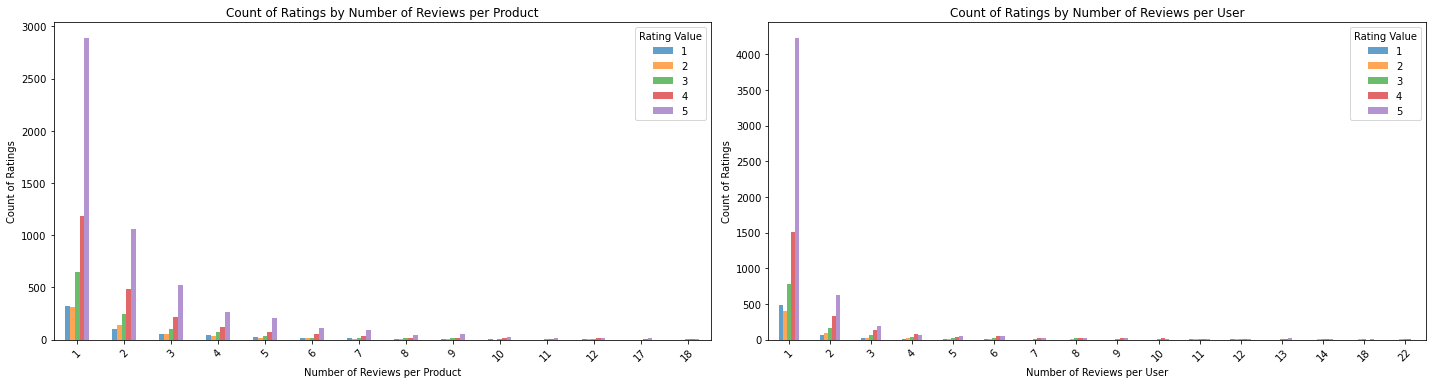

In [7]:
# Calculate number of reviews per Product and User
product_review_count = X_train['ProductId'].value_counts().reset_index()
product_review_count.columns = ['ProductId', 'Number of Reviews']
product_review_count['Rating'] = X_train.groupby('ProductId')['Score'].mean().reset_index()['Score']

user_review_count = X_train['UserId'].value_counts().reset_index()
user_review_count.columns = ['UserId', 'Number of Reviews']
user_review_count['Rating'] = X_train.groupby('UserId')['Score'].mean().reset_index()['Score']

# Create a DataFrame to count ratings based on review count for products
product_rating_counts = X_train.groupby('ProductId')['Score'].value_counts().unstack(fill_value=0)
product_rating_counts['Number of Reviews'] = product_review_count.set_index('ProductId')['Number of Reviews']
product_rating_counts = product_rating_counts.reset_index()

# Create a DataFrame to count ratings based on review count for users
user_rating_counts = X_train.groupby('UserId')['Score'].value_counts().unstack(fill_value=0)
user_rating_counts['Number of Reviews'] = user_review_count.set_index('UserId')['Number of Reviews']
user_rating_counts = user_rating_counts.reset_index()

# plots
plt.figure(figsize=(20, 10))

# Count of Ratings grouped by Number of Reviews per Product
plt.subplot(2, 2, 1)
product_rating_counts.groupby('Number of Reviews').sum().plot(kind='bar', ax=plt.gca(), alpha=0.7)
plt.xlabel('Number of Reviews per Product')
plt.ylabel('Count of Ratings')
plt.title('Count of Ratings by Number of Reviews per Product')
plt.xticks(rotation=45)
plt.legend(title='Rating Value', loc='upper right', labels=['1', '2', '3', '4', '5'])

# Count of Ratings grouped by Number of Reviews per User
plt.subplot(2, 2, 2)
user_rating_counts.groupby('Number of Reviews').sum().plot(kind='bar', ax=plt.gca(), alpha=0.7)
plt.xlabel('Number of Reviews per User')
plt.ylabel('Count of Ratings')
plt.title('Count of Ratings by Number of Reviews per User')
plt.xticks(rotation=45)
plt.legend(title='Rating Value', loc='upper right', labels=['1', '2', '3', '4', '5'])

# Display the combined plot
plt.tight_layout()
plt.show()

# Analyze Time

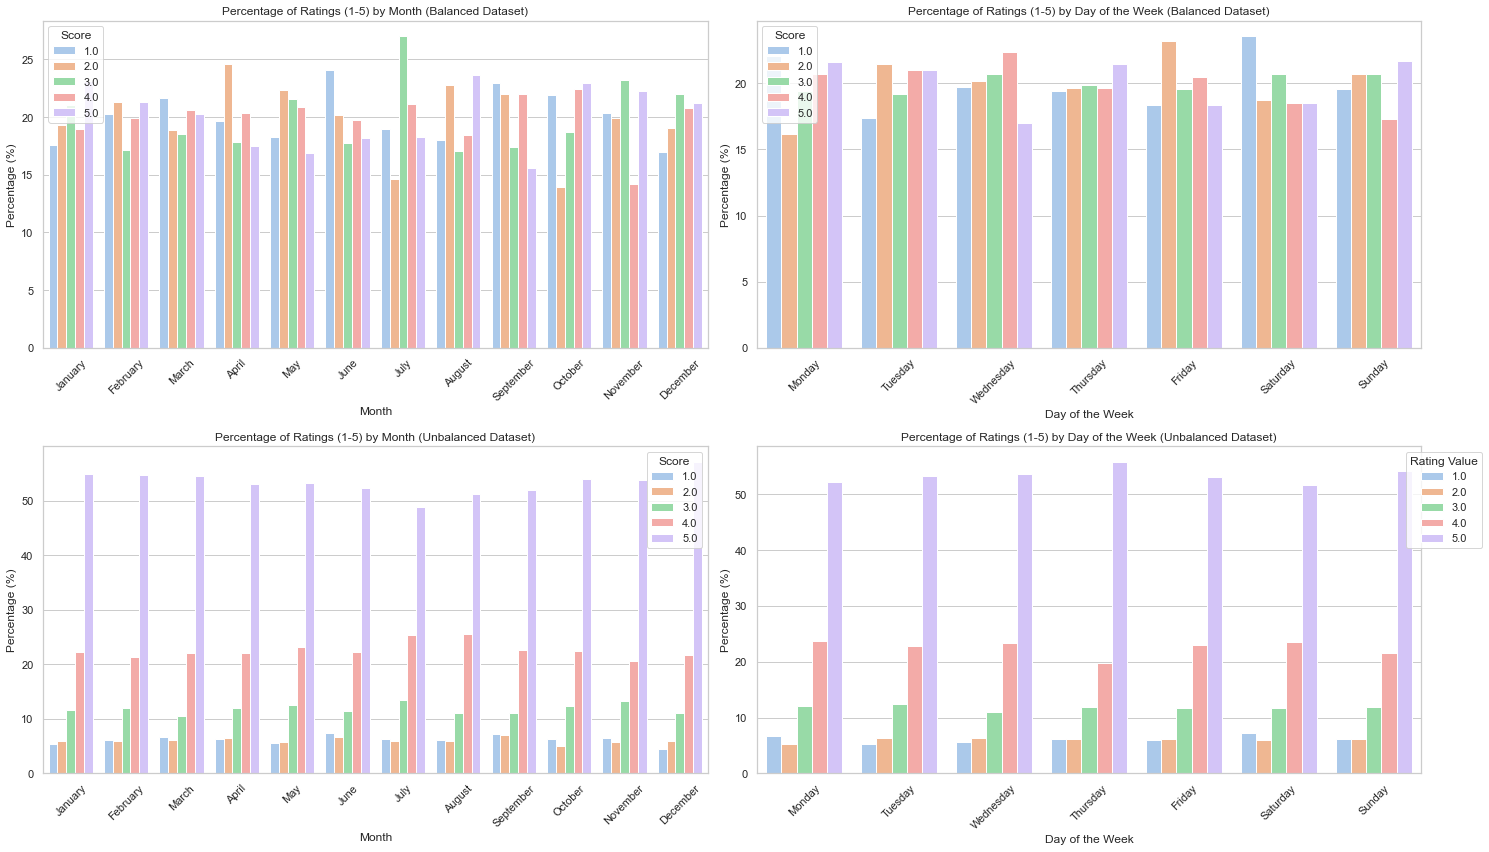

In [9]:
# Load the datasets
balanced_X_train = pd.read_csv("datasets/balanced_X_train.csv")
unbalanced_X_train = pd.read_csv("datasets/unbalanced_X_train.csv")

# Ensure the 'Time' column is in datetime format for both datasets
balanced_X_train['Time'] = pd.to_datetime(balanced_X_train['Time'])
unbalanced_X_train['Time'] = pd.to_datetime(unbalanced_X_train['Time'])

# Extract Month and Day of Week for balanced dataset
balanced_X_train['Month'] = balanced_X_train['Time'].dt.month_name()
balanced_X_train['DayOfWeek'] = balanced_X_train['Time'].dt.day_name()

# Extract Month and Day of Week for unbalanced dataset
unbalanced_X_train['Month'] = unbalanced_X_train['Time'].dt.month_name()
unbalanced_X_train['DayOfWeek'] = unbalanced_X_train['Time'].dt.day_name()

# Create frequency tables for balanced dataset
month_frequency_balanced = balanced_X_train.groupby(['Month', 'Score']).size().reset_index(name='Frequency')
day_frequency_balanced = balanced_X_train.groupby(['DayOfWeek', 'Score']).size().reset_index(name='Frequency')

# Create frequency tables for unbalanced dataset
month_frequency_unbalanced = unbalanced_X_train.groupby(['Month', 'Score']).size().reset_index(name='Frequency')
day_frequency_unbalanced = unbalanced_X_train.groupby(['DayOfWeek', 'Score']).size().reset_index(name='Frequency')

# Calculate percentages for balanced dataset
month_totals_balanced = month_frequency_balanced.groupby('Month')['Frequency'].transform('sum')
month_frequency_balanced['Percentage'] = (month_frequency_balanced['Frequency'] / month_totals_balanced) * 100

day_totals_balanced = day_frequency_balanced.groupby('DayOfWeek')['Frequency'].transform('sum')
day_frequency_balanced['Percentage'] = (day_frequency_balanced['Frequency'] / day_totals_balanced) * 100

# Calculate percentages for unbalanced dataset
month_totals_unbalanced = month_frequency_unbalanced.groupby('Month')['Frequency'].transform('sum')
month_frequency_unbalanced['Percentage'] = (month_frequency_unbalanced['Frequency'] / month_totals_unbalanced) * 100

day_totals_unbalanced = day_frequency_unbalanced.groupby('DayOfWeek')['Frequency'].transform('sum')
day_frequency_unbalanced['Percentage'] = (day_frequency_unbalanced['Frequency'] / day_totals_unbalanced) * 100

# Reorder Month and Day of Week for better visualization
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Sort frequency DataFrames
month_frequency_balanced['Month'] = pd.Categorical(month_frequency_balanced['Month'], categories=month_order, ordered=True)
month_frequency_balanced = month_frequency_balanced.sort_values('Month')

day_frequency_balanced['DayOfWeek'] = pd.Categorical(day_frequency_balanced['DayOfWeek'], categories=day_order, ordered=True)
day_frequency_balanced = day_frequency_balanced.sort_values('DayOfWeek')

month_frequency_unbalanced['Month'] = pd.Categorical(month_frequency_unbalanced['Month'], categories=month_order, ordered=True)
month_frequency_unbalanced = month_frequency_unbalanced.sort_values('Month')

day_frequency_unbalanced['DayOfWeek'] = pd.Categorical(day_frequency_unbalanced['DayOfWeek'], categories=day_order, ordered=True)
day_frequency_unbalanced = day_frequency_unbalanced.sort_values('DayOfWeek')

# Set the style for seaborn
sns.set(style='whitegrid')

# Create a color palette for the ratings
palette = sns.color_palette("pastel", n_colors=5)

# Create subplots for 4 graphs
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plotting the percentage of ratings by month (Balanced Dataset)
sns.barplot(data=month_frequency_balanced, x='Month', y='Percentage', hue='Score', palette=palette, ax=axes[0, 0])
axes[0, 0].set_title('Percentage of Ratings (1-5) by Month (Balanced Dataset)')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Percentage (%)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plotting the percentage of ratings by day of the week (Balanced Dataset)
sns.barplot(data=day_frequency_balanced, x='DayOfWeek', y='Percentage', hue='Score', palette=palette, ax=axes[0, 1])
axes[0, 1].set_title('Percentage of Ratings (1-5) by Day of the Week (Balanced Dataset)')
axes[0, 1].set_xlabel('Day of the Week')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plotting the percentage of ratings by month (Unbalanced Dataset)
sns.barplot(data=month_frequency_unbalanced, x='Month', y='Percentage', hue='Score', palette=palette, ax=axes[1, 0])
axes[1, 0].set_title('Percentage of Ratings (1-5) by Month (Unbalanced Dataset)')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Percentage (%)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plotting the percentage of ratings by day of the week (Unbalanced Dataset)
sns.barplot(data=day_frequency_unbalanced, x='DayOfWeek', y='Percentage', hue='Score', palette=palette, ax=axes[1, 1])
axes[1, 1].set_title('Percentage of Ratings (1-5) by Day of the Week (Unbalanced Dataset)')
axes[1, 1].set_xlabel('Day of the Week')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.legend(title='Rating Value', loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

# Analyze Text

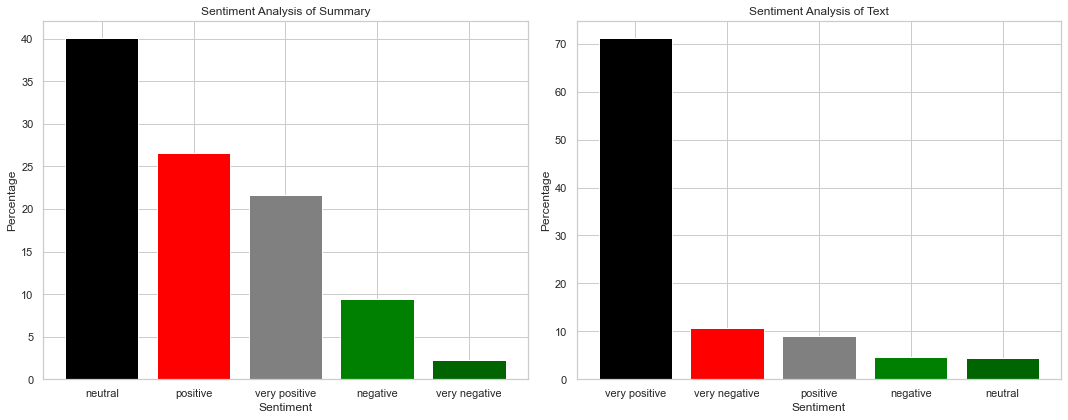

Correlation between Summary Sentiment and Rating Score: 0.3488
Correlation between Text Sentiment and Rating Score: 0.3412


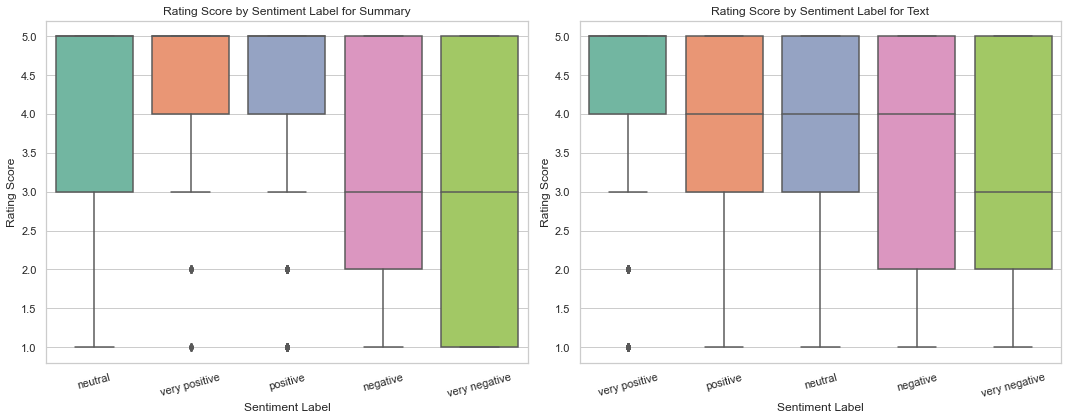

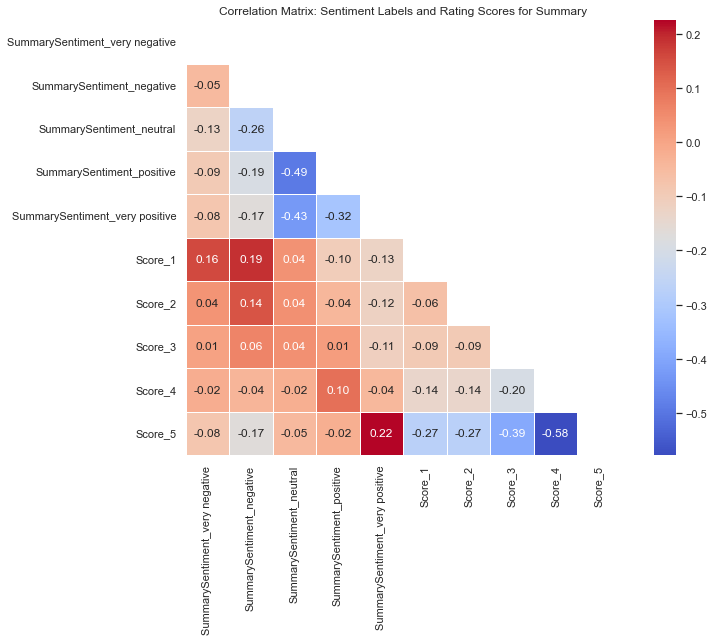

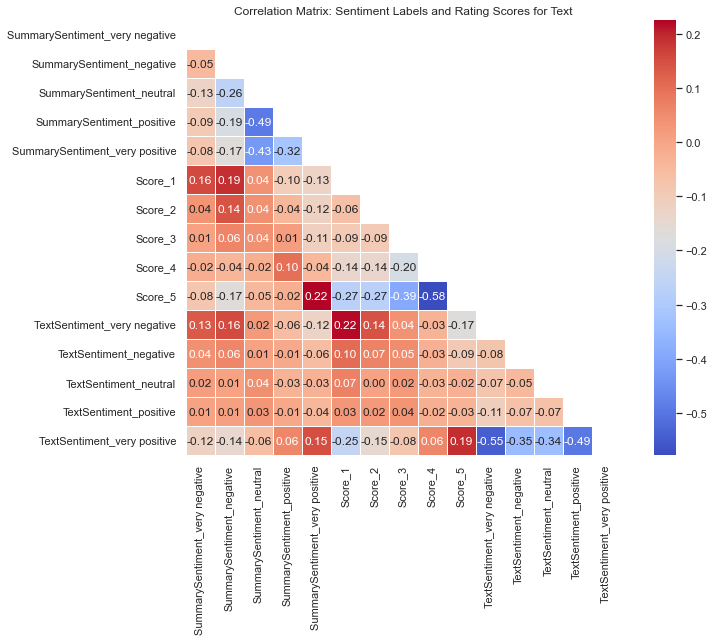

In [10]:
# Load the processed data from the CSV file
processed_data = pd.read_csv("datasets/X_train.csv")

# Function to visualize sentiment analysis results
def visualize_sentiment(data):
    # Create a figure for the sentiment percentage distribution
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Analyze both columns: 'Summary' and 'Text'
    for i, col in enumerate(['SummarySentiment', 'TextSentiment']):
        # Calculate sentiment counts and visualize the distribution
        sentiment_counts = data[col].value_counts(normalize=True) * 100
        axes[i].bar(sentiment_counts.index, sentiment_counts.values, color=['black', 'red', 'gray', 'green', 'darkgreen'])
        axes[i].set_title(f'Sentiment Analysis of {col.replace("Sentiment", "")}')
        axes[i].set_xlabel('Sentiment')
        axes[i].set_ylabel('Percentage')
        axes[i].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()

    # Create a figure for the boxplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Sentiment mapping for numerical values
    sentiment_mapping = {
        'very negative': 1,
        'negative': 2,
        'neutral': 3,
        'positive': 4,
        'very positive': 5
    }

    # Analyze both columns again for the boxplots
    for i, col in enumerate(['SummarySentiment', 'TextSentiment']):
        # Convert sentiment labels to numeric values
        data[f'{col}_numeric'] = data[col].map(sentiment_mapping)

        # Calculate correlation between sentiment and rating scores
        correlation = data[['Score', f'{col}_numeric']].corr().iloc[0, 1]
        print(f"Correlation between {col.replace('Sentiment', '')} Sentiment and Rating Score: {correlation:.4f}")

        # Visualize the correlation
        sns.boxplot(data=data, x=col, y='Score', palette='Set2', ax=axes[i])
        axes[i].set_title(f'Rating Score by Sentiment Label for {col.replace("Sentiment", "")}')
        axes[i].set_xlabel('Sentiment Label')
        axes[i].set_ylabel('Rating Score')
        axes[i].tick_params(axis='x', rotation=15)

    plt.tight_layout()
    plt.show()

    # Create a DataFrame for correlation analysis
    correlation_data = pd.DataFrame()

    # Add the sentiment numeric values for both columns
    for col in ['SummarySentiment', 'TextSentiment']:
        for sentiment, numeric_value in sentiment_mapping.items():
            correlation_data[f'{col}_{sentiment}'] = (data[col] == sentiment).astype(int)

        # Add the rating score as columns for 1 to 5
        for score in range(1, 6):
            correlation_data[f'Score_{score}'] = (data['Score'] == score).astype(int)

        # Calculate and display the correlation matrix
        correlation_matrix = correlation_data.corr()

        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

        # Visualize the lower triangle of the correlation matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
        plt.title(f'Correlation Matrix: Sentiment Labels and Rating Scores for {col.replace("Sentiment", "")}')
        plt.show()

# Visualize sentiment for the dataset
visualize_sentiment(processed_data)

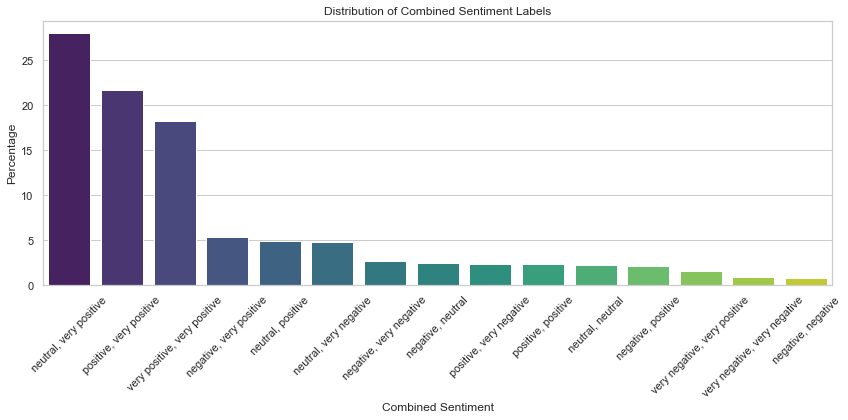

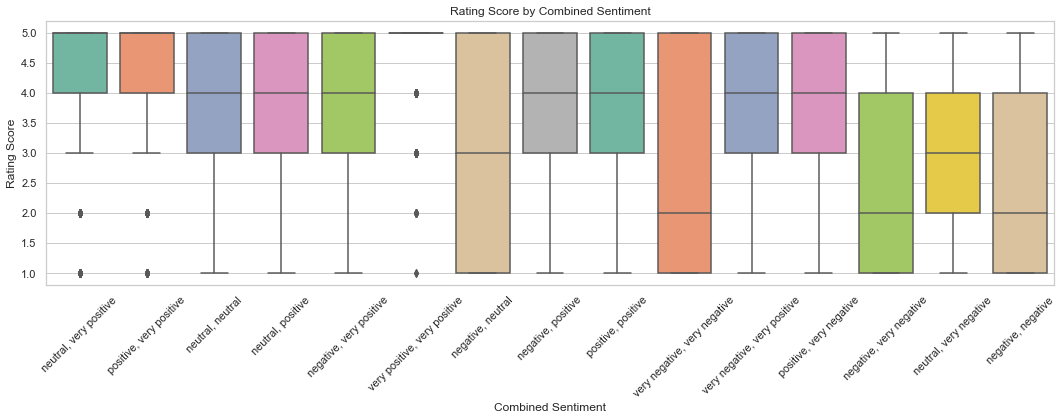

In [11]:
# Function to visualize sentiment combinations
def visualize_combined_sentiment(data):
    # Create a new column for combined sentiment
    data['CombinedSentiment'] = data.apply(
        lambda row: ', '.join(sorted([row['SummarySentiment'], row['TextSentiment']])), axis=1
    )

    # Calculate and visualize the distribution of combined sentiments
    combined_sentiment_counts = data['CombinedSentiment'].value_counts(normalize=True) * 100
    plt.figure(figsize=(12, 6))
    sns.barplot(x=combined_sentiment_counts.index, y=combined_sentiment_counts.values, palette='viridis')
    plt.title('Distribution of Combined Sentiment Labels')
    plt.xlabel('Combined Sentiment')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Create a boxplot to visualize rating scores by combined sentiment
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=data, x='CombinedSentiment', y='Score', palette='Set2')
    plt.title('Rating Score by Combined Sentiment')
    plt.xlabel('Combined Sentiment')
    plt.ylabel('Rating Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualize the combined sentiment for the dataset
visualize_combined_sentiment(processed_data)

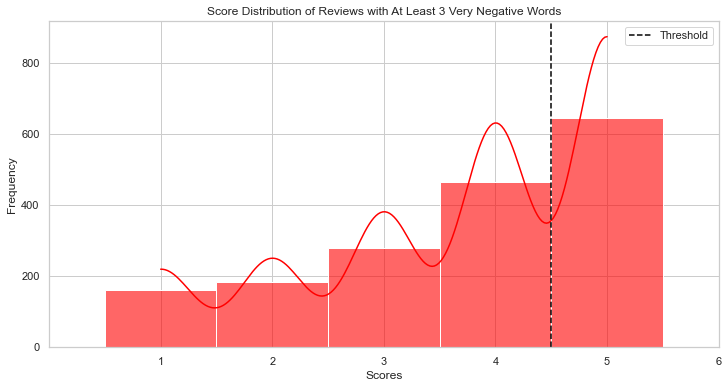

In [12]:
# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to count very positive and very negative words
def count_very_positive_negative(text):
    words = text.split()
    very_positive_count = sum(1 for word in words if sia.polarity_scores(word)['compound'] >= 0.5)
    very_negative_count = sum(1 for word in words if sia.polarity_scores(word)['compound'] <= -0.5)
    return very_positive_count, very_negative_count

# Apply the function to count very positive and very negative words
unbalanced_data[['VeryPositiveCount', 'VeryNegativeCount']] = unbalanced_data['Text'].apply(
    lambda x: pd.Series(count_very_positive_negative(x))
)

# Filter reviews with at least 3 "very negative" words
very_negative_reviews = unbalanced_data[unbalanced_data['VeryNegativeCount'] >= 3]

# Display score distribution for very negative reviews
negative_score_distribution = very_negative_reviews[['Score', 'VeryNegativeCount']]

# Visualization of score distribution for very negative reviews
plt.figure(figsize=(12, 6))
sns.histplot(very_negative_reviews['Score'], bins=np.arange(0.5, 6, 1), kde=True, color='red', alpha=0.6)
plt.title('Score Distribution of Reviews with At Least 3 Very Negative Words')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.xlim(0, 6)
plt.xticks(np.arange(1, 7, 1))
plt.axvline(x=4.5, color='black', linestyle='--', label='Threshold')
plt.legend()
plt.show()

# Sample + Split into training and testing set

In [14]:
# Load your balanced dataset
balanced_data = pd.read_csv("datasets/balanced_X_train.csv")

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    balanced_data.drop(columns=['Score']),
    balanced_data['Score'],
    random_state=0
)

# Feature Selection

In [15]:
features = ['UserFrequency', 'ProductFrequency', 'SummarySentimentScore', 'TextSentimentScore', 'Helpfulness', 'Year', 'Month', 'Day']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

In [16]:
# Split the balanced dataset into training and testing sets
X_train_balanced, X_test_balanced, Y_train_balanced, Y_test_balanced = train_test_split(
    balanced_data[features],
    balanced_data['Score'],
    random_state=0
)

# Split the unbalanced dataset into training and testing sets
X_train_unbalanced, X_test_unbalanced, Y_train_unbalanced, Y_test_unbalanced = train_test_split(
    unbalanced_data[features],
    unbalanced_data['Score'],
    random_state=0
)

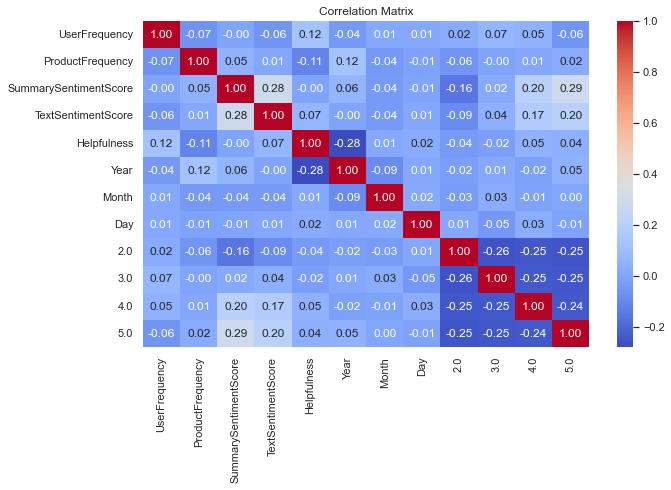

In [17]:
# One-hot encoding on the 'Score' column after splitting
Y_train_encoded = pd.get_dummies(Y_train, drop_first=True)
Y_test_encoded = pd.get_dummies(Y_test, drop_first=True)

# Combine the features and the one-hot encoded target variable into one DataFrame
combined_data = X_train_select.copy()
# Adding the one-hot encoded scores (using the first column as an example)
combined_data = pd.concat([combined_data, Y_train_encoded], axis=1)

# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


# Examine different Models

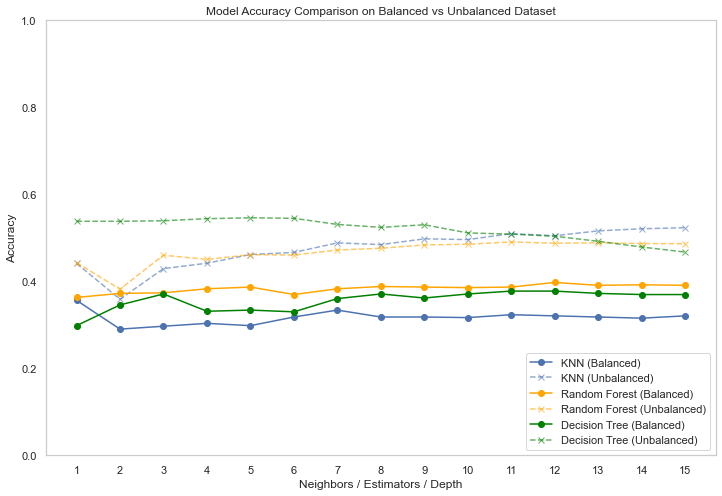

In [18]:
# Load your balanced dataset
balanced_data = pd.read_csv("datasets/balanced_X_train.csv")

# Load your unbalanced dataset
unbalanced_data = pd.read_csv("datasets/unbalanced_X_train.csv")

# Features to be used for training
features = ['UserFrequency', 'SummarySentimentScore', 'TextSentimentScore', 'Helpfulness', 'Year']

# Function to train and evaluate models
def train_and_evaluate(X_train, X_test, Y_train, Y_test, neighbors_range, estimators_range, max_depth_range):
    accuracy_scores_knn = []
    accuracy_scores_rf = []
    accuracy_scores_dt = []

    # Loop through the range of neighbors for KNN
    for n_neighbors in neighbors_range:
        model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        model_knn.fit(X_train, Y_train)
        Y_test_predictions_knn = model_knn.predict(X_test)
        accuracy_knn = accuracy_score(Y_test, Y_test_predictions_knn)
        accuracy_scores_knn.append(accuracy_knn)

    # Loop through the range of estimators for Random Forest
    for n_estimators in estimators_range:
        model_rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        model_rf.fit(X_train, Y_train)
        Y_test_predictions_rf = model_rf.predict(X_test)
        accuracy_rf = accuracy_score(Y_test, Y_test_predictions_rf)
        accuracy_scores_rf.append(accuracy_rf)

    # Loop through the range of depths for Decision Trees
    for max_depth in max_depth_range:
        model_dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        model_dt.fit(X_train, Y_train)
        Y_test_predictions_dt = model_dt.predict(X_test)
        accuracy_dt = accuracy_score(Y_test, Y_test_predictions_dt)
        accuracy_scores_dt.append(accuracy_dt)

    return accuracy_scores_knn, accuracy_scores_rf, accuracy_scores_dt

# Split the balanced dataset using specified features
X_balanced = balanced_data[features]
Y_balanced = balanced_data['Score']
X_train_balanced, X_test_balanced, Y_train_balanced, Y_test_balanced = train_test_split(
    X_balanced,
    Y_balanced,
    random_state=0
)

# Split the unbalanced dataset using specified features
X_unbalanced = unbalanced_data[features]
Y_unbalanced = unbalanced_data['Score']
X_train_unbalanced, X_test_unbalanced, Y_train_unbalanced, Y_test_unbalanced = train_test_split(
    X_unbalanced,
    Y_unbalanced,
    random_state=0
)

# Define a range of values for n_neighbors, n_estimators, and max_depth
neighbors_range = range(1, 16)
estimators_range = range(1, 16)
max_depth_range = range(1, 16)

# Train and evaluate on the balanced dataset
accuracy_scores_knn_balanced, accuracy_scores_rf_balanced, accuracy_scores_dt_balanced = train_and_evaluate(
    X_train_balanced, X_test_balanced, Y_train_balanced, Y_test_balanced, neighbors_range, estimators_range, max_depth_range
)

# Train and evaluate on the unbalanced dataset
accuracy_scores_knn_unbalanced, accuracy_scores_rf_unbalanced, accuracy_scores_dt_unbalanced = train_and_evaluate(
    X_train_unbalanced, X_test_unbalanced, Y_train_unbalanced, Y_test_unbalanced, neighbors_range, estimators_range, max_depth_range
)

# Plotting the results for both datasets on the same graph
plt.figure(figsize=(12, 8))

# KNN Accuracy on both datasets
plt.plot(neighbors_range, accuracy_scores_knn_balanced, marker='o', linestyle='-', color='b', label='KNN (Balanced)')
plt.plot(neighbors_range, accuracy_scores_knn_unbalanced, marker='x', linestyle='--', color='b', label='KNN (Unbalanced)', alpha=0.6)

# Random Forest Accuracy on both datasets
plt.plot(estimators_range, accuracy_scores_rf_balanced, marker='o', linestyle='-', color='orange', label='Random Forest (Balanced)')
plt.plot(estimators_range, accuracy_scores_rf_unbalanced, marker='x', linestyle='--', color='orange', label='Random Forest (Unbalanced)', alpha=0.6)

# Decision Tree Accuracy on both datasets
plt.plot(max_depth_range, accuracy_scores_dt_balanced, marker='o', linestyle='-', color='green', label='Decision Tree (Balanced)')
plt.plot(max_depth_range, accuracy_scores_dt_unbalanced, marker='x', linestyle='--', color='green', label='Decision Tree (Unbalanced)', alpha=0.6)

plt.title('Model Accuracy Comparison on Balanced vs Unbalanced Dataset')
plt.xlabel('Neighbors / Estimators / Depth')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 16, 1))
plt.grid()
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()


# Additional Models:

In [19]:
# Initialize the Decision Tree model with specified parameters
model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=2, random_state=42)

# Fit the model on the balanced dataset
model.fit(X_train_balanced, Y_train_balanced)

# Predict and evaluate on the balanced dataset
Y_train_pred_balanced = model.predict(X_train_balanced)
Y_test_pred_balanced = model.predict(X_test_balanced)

# Calculate accuracies
train_accuracy_balanced = accuracy_score(Y_train_balanced, Y_train_pred_balanced)
test_accuracy_balanced = accuracy_score(Y_test_balanced, Y_test_pred_balanced)

# Fit the model on the unbalanced dataset
model.fit(X_train_unbalanced, Y_train_unbalanced)

# Predict and evaluate on the unbalanced dataset
Y_train_pred_unbalanced = model.predict(X_train_unbalanced)
Y_test_pred_unbalanced = model.predict(X_test_unbalanced)

# Calculate accuracies
train_accuracy_unbalanced = accuracy_score(Y_train_unbalanced, Y_train_pred_unbalanced)
test_accuracy_unbalanced = accuracy_score(Y_test_unbalanced, Y_test_pred_unbalanced)

# Feature importance
feature_importance = model.feature_importances_

# Round feature importance to 3 decimal places
rounded_feature_importance = np.round(feature_importance, 3)

# Displaying the results
print("Balanced Dataset:")
print(f"Training Accuracy: {train_accuracy_balanced:.2f}")
print(f"Testing Accuracy: {test_accuracy_balanced:.2f}")
print(f"Feature Importance: {dict(zip(features, rounded_feature_importance))}\n")

print("Unbalanced Dataset:")
print(f"Training Accuracy: {train_accuracy_unbalanced:.2f}")
print(f"Testing Accuracy: {test_accuracy_unbalanced:.2f}")
print(f"Feature Importance: {dict(zip(features, rounded_feature_importance))}\n")

# Create score distribution tables for both datasets
score_distribution_balanced = pd.DataFrame(Y_test_pred_balanced, columns=['Predicted Score'])
score_distribution_unbalanced = pd.DataFrame(Y_test_pred_unbalanced, columns=['Predicted Score'])

# Get frequency counts
score_counts_balanced = score_distribution_balanced['Predicted Score'].value_counts().reset_index()
score_counts_balanced.columns = ['Score', 'Frequency']

score_counts_unbalanced = score_distribution_unbalanced['Predicted Score'].value_counts().reset_index()
score_counts_unbalanced.columns = ['Score', 'Frequency']

# Display the score distributions
print("Score Distribution (Balanced Dataset):")
print(score_counts_balanced)

print("\nScore Distribution (Unbalanced Dataset):")
print(score_counts_unbalanced)

Balanced Dataset:
Training Accuracy: 0.45
Testing Accuracy: 0.33
Feature Importance: {'UserFrequency': 0.077, 'SummarySentimentScore': 0.471, 'TextSentimentScore': 0.218, 'Helpfulness': 0.163, 'Year': 0.071}

Unbalanced Dataset:
Training Accuracy: 0.57
Testing Accuracy: 0.55
Feature Importance: {'UserFrequency': 0.077, 'SummarySentimentScore': 0.471, 'TextSentimentScore': 0.218, 'Helpfulness': 0.163, 'Year': 0.071}

Score Distribution (Balanced Dataset):
   Score  Frequency
0    3.0        178
1    2.0        171
2    1.0        167
3    4.0        126
4    5.0        113

Score Distribution (Unbalanced Dataset):
   Score  Frequency
0    5.0       2201
1    1.0        143
2    2.0         66
3    4.0         61
4    3.0         29


In [20]:
# Function to assign scores based on sentiment combinations
def assign_score(row):
    summary_sentiment = row['SummarySentiment']
    text_sentiment = row['TextSentiment']

    if summary_sentiment == 'very positive' and text_sentiment == 'very positive':
        return 5
    elif (summary_sentiment in ['neutral', 'positive']) and (text_sentiment == 'very positive'):
        return 5
    elif (summary_sentiment in ['neutral', 'negative']) and (text_sentiment == 'very negative'):
        return row['Score']  # Keep the original score (1, 2, or 3)
    else:
        return row['Score']  # Default case, keep the original score

# Apply the scoring function to create a new score column
unbalanced_data['NewScore'] = unbalanced_data.apply(assign_score, axis=1)

# Prepare the feature and target variables
features = ['Helpfulness', 'UserFrequency', 'SummarySentimentScore', 'TextSentimentScore', 'Year']
X = unbalanced_data[features]
Y = unbalanced_data['NewScore']


# Initialize the Decision Tree model with specified parameters
model = DecisionTreeClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=2, random_state=42)

# Fit the model on the unbalanced dataset
model.fit(X_train_unbalanced, Y_train_unbalanced)

# Predict and evaluate on the unbalanced dataset
Y_train_pred_unbalanced = model.predict(X_train_unbalanced)
Y_test_pred_unbalanced = model.predict(X_test_unbalanced)

# Calculate accuracies
train_accuracy_unbalanced = accuracy_score(Y_train_unbalanced, Y_train_pred_unbalanced)
test_accuracy_unbalanced = accuracy_score(Y_test_unbalanced, Y_test_pred_unbalanced)

# Feature importance
feature_importance = model.feature_importances_

# Round feature importance to 3 decimal places
rounded_feature_importance = np.round(feature_importance, 3)

# Displaying the results
print("Unbalanced Dataset:")
print(f"Training Accuracy: {train_accuracy_unbalanced:.2f}")
print(f"Testing Accuracy: {test_accuracy_unbalanced:.2f}")
print(f"Feature Importance: {dict(zip(features, rounded_feature_importance))}\n")

Unbalanced Dataset:
Training Accuracy: 0.58
Testing Accuracy: 0.53
Feature Importance: {'Helpfulness': 0.089, 'UserFrequency': 0.422, 'SummarySentimentScore': 0.237, 'TextSentimentScore': 0.16, 'Year': 0.092}

